# Title: The NFL Contention Cycle

#### **Visualizing how NFL teams have transitioned between rebuilding and competing over the last decade.**

In the NFL, success is fleeting. Dynasties rise and fall, rebuilds succeed and fail, and every season brings new contenders. But what if we could visualize this constant churn? What if we could see how teams move through the competitive landscape over time—from rebuilding to contending, from elite to struggling, and back again?

In [9]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image as PILImage
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, Image
import matplotlib

To visualize this cycle, I've mapped each team's position along two dimensions: their **present** performance (how good they are right now) versus their **future** outlook (how good they're expected to be over the next few seasons). Teams in the top-right quadrant are both good now and have a bright future—these are the true contenders. Teams in the bottom-left are struggling now with little hope ahead—these are the rebuilders. The other quadrants represent teams in transition: good now but declining (top-left), or struggling now but building toward something better (bottom-right).

**The Data**

The **present** value I used for each season is ESPN's end-of-season Football Power Index (FPI), which ESPN describes as the "expected point margin vs an average opponent on a neutral field." [These numbers for the past 10 years can be found here.](https://www.espn.com/nfl/fpi)

The **future** value is derived from ESPN's future power rating from the following offseason, which looks to estimate how a team will perform over the next 3 seasons. [The 2025 numbers and the methodology for this can be found here.](https://www.espn.com/nfl/story/_/id/45920966/2025-nfl-future-power-rankings-projections-32-teams-roster-coaching-quarterback)

By pairing these two metrics, we can see not just where teams are, but where they're heading—and how that trajectory has changed over the past decade.

In [10]:
# import data
present = pd.read_csv("./NFL Power Rankings - Power Index.csv")
future = pd.read_csv("./NFL Power Rankings - Future.csv")

In [11]:
# decrement all columns (except "Team") by 1 year in the 'future' DataFrame
cols_to_rename = {col: str(int(col)-1) for col in future.columns if col != 'Team' and col.isdigit()}
future.rename(columns=cols_to_rename, inplace=True)

**2024 Snapshot**

Let's start with a snapshot of where teams stood at the end of the 2024 season. Each team's logo is positioned based on their present performance (y-axis) and future outlook (x-axis).


In [12]:
# This code assumes you have a folder called "nfl_logos" in the same directory as the notebook,
# and the logos are named by team abbreviation, e.g.: ARI.png, ATL.png, etc.

# Create a DataFrame containing team, and corresponding logo image path or loaded image.
logo_dir = "./nfl_logos"
logo_paths = []
logos = []

for team in present["Team"]:
    logo_path = os.path.join(logo_dir, f"{team}.png")
    logo_paths.append(logo_path)
    # Try to open and store the PIL image object for convenience (can use in plotting)
    if os.path.exists(logo_path):
        logos.append(PILImage.open(logo_path))
    else:
        logos.append(None)

team_logos_df = pd.DataFrame({
    "Team": present["Team"],
    "LogoPath": logo_paths,
    "LogoImage": logos
})

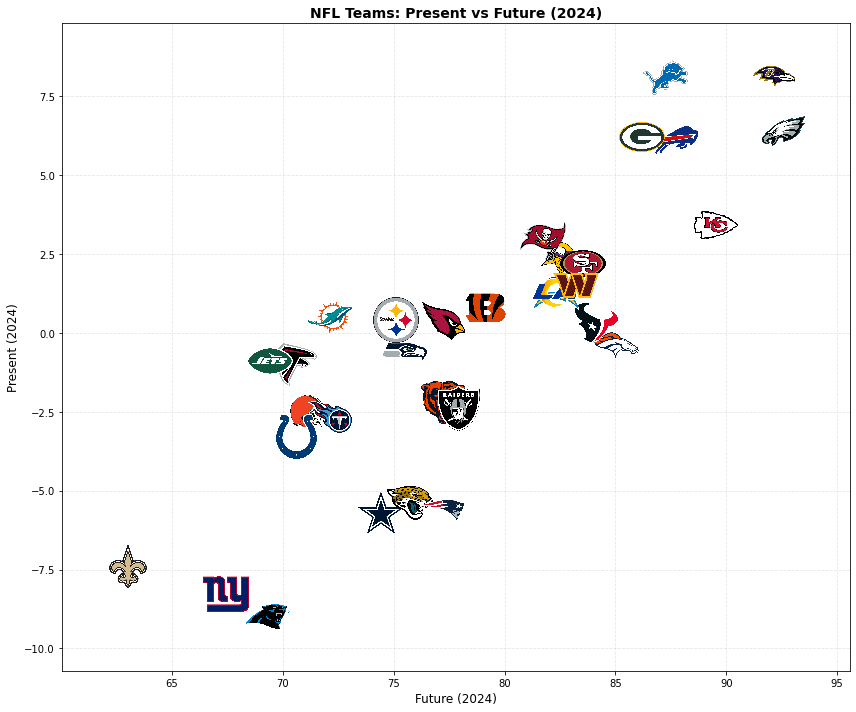

In [ ]:
# Plot teams' 2024 present (y-axis) vs future (x-axis) with team logos as points

# Merge present and future data for 2024
plot_data = pd.merge(
    present[['Team', '2024']].rename(columns={'2024': 'Present'}),
    future[['Team', '2024']].rename(columns={'2024': 'Future'}),
    on='Team'
)

# Merge with logo paths
plot_data = pd.merge(plot_data, team_logos_df[['Team', 'LogoPath']], on='Team')

# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Set axis limits with some padding
x_min, x_max = plot_data['Future'].min(), plot_data['Future'].max()
y_min, y_max = plot_data['Present'].min(), plot_data['Present'].max()
x_padding = (x_max - x_min) * 0.1
y_padding = (y_max - y_min) * 0.1

ax.set_xlim(x_min - x_padding, x_max + x_padding)
ax.set_ylim(y_min - y_padding, y_max + y_padding)

# Plot each team logo at its coordinates
for idx, row in plot_data.iterrows():
    logo_path = row['LogoPath']
    if os.path.exists(logo_path):
        # Load image fresh
        img = PILImage.open(logo_path)
        # Convert to RGBA if needed
        if img.mode != 'RGBA':
            img = img.convert('RGBA')
        logo_array = np.array(img)
        
        # Create OffsetImage with zoom
        imagebox = OffsetImage(logo_array, zoom=0.05)
        
        # Create AnnotationBbox
        ab = AnnotationBbox(imagebox, (row['Future'], row['Present']), 
                           frameon=False, pad=0)
        ax.add_artist(ab)

# Set labels and title
ax.set_xlabel('Future', fontsize=12)
ax.set_ylabel('Present', fontsize=12)
ax.set_title('NFL Contention Cycle (2024)', fontsize=14, fontweight='bold')

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


**The Cycle in Motion**

A single snapshot tells part of the story, but the real magic happens when we watch teams move through this space over time. The animation below shows how NFL teams have transitioned between rebuilding and contending from 2015 through 2024. Watch as teams move across the plot—some making steady climbs toward contention, others falling back, and a few maintaining elite status year after year.

![NFL Cycle Animation](/assets/images/2026-1-8-NFL_cycle/nfl_cycle_animation.gif)


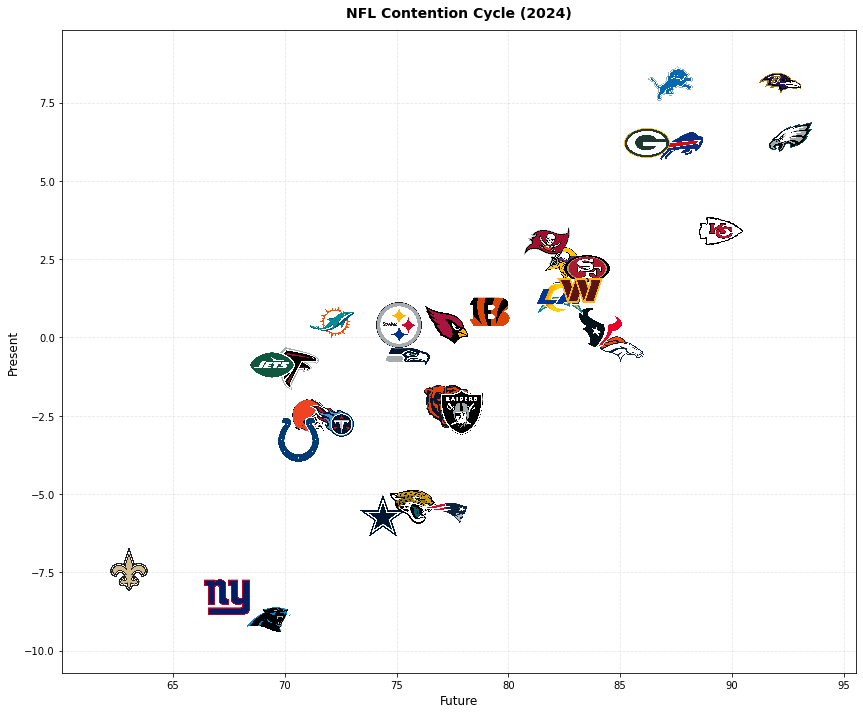

In [15]:
# Animated plot showing teams moving smoothly through years

# Set animation embed limit to allow larger animations (in MB)
matplotlib.rcParams['animation.embed_limit'] = 1000

# Get all available years (overlapping years between present and future)
# Reverse order: start at 2015, go to 2024
present_years = [col for col in present.columns if col.isdigit()]
future_years = [col for col in future.columns if col.isdigit()]
years = sorted([int(y) for y in present_years if y in future_years], reverse=False)

# Prepare data for all years
all_data = {}
for year in years:
    year_str = str(year)
    plot_data = pd.merge(
        present[['Team', year_str]].rename(columns={year_str: 'Present'}),
        future[['Team', year_str]].rename(columns={year_str: 'Future'}),
        on='Team'
    )
    plot_data = pd.merge(plot_data, team_logos_df[['Team', 'LogoPath']], on='Team')
    all_data[year] = plot_data

# Create figure for animation
fig_anim, ax_anim = plt.subplots(figsize=(12, 10))
ax_anim.set_xlabel('Future', fontsize=12)
ax_anim.set_ylabel('Present', fontsize=12)
ax_anim.grid(True, alpha=0.3, linestyle='--')
# Ensure axes are visible
ax_anim.spines['bottom'].set_visible(True)
ax_anim.spines['left'].set_visible(True)
ax_anim.spines['top'].set_visible(True)
ax_anim.spines['right'].set_visible(True)

# Pre-load all logo images
logo_images = {}
for idx, row in team_logos_df.iterrows():
    logo_path = row['LogoPath']
    if os.path.exists(logo_path):
        img = PILImage.open(logo_path)
        if img.mode != 'RGBA':
            img = img.convert('RGBA')
        logo_array = np.array(img)
        logo_images[row['Team']] = logo_array

# Create interpolated frames with pauses at each year
frames_per_transition = 40  # More frames for smoother animation
pause_frames = 15  # Pause frames at each year
total_frames = len(years) * pause_frames + (len(years) - 1) * frames_per_transition

# Store annotation boxes
annotation_boxes = []

# Title text
title_text = ax_anim.text(0.5, 1.02, f'NFL Contention Cycle ({years[0]})', 
                          transform=ax_anim.transAxes, fontsize=14, 
                          fontweight='bold', ha='center')

def get_interpolated_data(frame):
    """Get interpolated data for a given frame number"""
    frame_idx = 0
    
    for year_idx in range(len(years)):
        # Check if we're in the pause period for this year
        if frame_idx <= frame < frame_idx + pause_frames:
            # Pause at this year
            year = years[year_idx]
            year_data = all_data[year].set_index('Team')
            return year_data[['Future', 'Present', 'LogoPath']].reset_index(), year
        
        frame_idx += pause_frames
        
        # Check if we're in the transition to next year
        if year_idx < len(years) - 1:
            if frame_idx <= frame < frame_idx + frames_per_transition:
                # Transition between years
                current_year = years[year_idx]
                next_year = years[year_idx + 1]
                transition_frame = frame - frame_idx
                alpha = transition_frame / frames_per_transition
                
                current_data = all_data[current_year].set_index('Team')
                next_data = all_data[next_year].set_index('Team')
                
                # Interpolate between current and next year
                interpolated = pd.DataFrame(index=current_data.index)
                interpolated['Future'] = (1 - alpha) * current_data['Future'] + alpha * next_data['Future']
                interpolated['Present'] = (1 - alpha) * current_data['Present'] + alpha * next_data['Present']
                interpolated['LogoPath'] = current_data['LogoPath']
                
                # Determine display year (round to nearest)
                display_year = int(round((1 - alpha) * current_year + alpha * next_year))
                return interpolated.reset_index(), display_year
            
            frame_idx += frames_per_transition
    
    # Last frame - use last year
    year = years[-1]
    year_data = all_data[year].set_index('Team')
    return year_data[['Future', 'Present', 'LogoPath']].reset_index(), year

def animate(frame):
    year_data, display_year = get_interpolated_data(frame)
    
    # Clear previous annotation boxes
    for ab in annotation_boxes:
        ab.remove()
    annotation_boxes.clear()
    
    # Calculate dynamic axis limits based on current data
    x_min, x_max = year_data['Future'].min(), year_data['Future'].max()
    y_min, y_max = year_data['Present'].min(), year_data['Present'].max()
    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1
    
    # Update axis limits dynamically
    ax_anim.set_xlim(x_min - x_padding, x_max + x_padding)
    ax_anim.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Update title
    title_text.set_text(f'NFL Contention Cycle ({display_year})')
    
    # Create new annotation boxes at interpolated positions
    for idx, row in year_data.iterrows():
        team = row['Team']
        if team in logo_images:
            imagebox = OffsetImage(logo_images[team], zoom=0.05)
            ab = AnnotationBbox(imagebox, (row['Future'], row['Present']), 
                               frameon=False, pad=0)
            ax_anim.add_artist(ab)
            annotation_boxes.append(ab)
    
    return annotation_boxes + [title_text]

# Create animation
anim = FuncAnimation(fig_anim, animate, frames=total_frames, 
                     interval=50, blit=False, repeat=True)

plt.tight_layout()

# Save as GIF (slower fps for smoother, slower animation)
# Save to images directory (will be copied to assets by workflow)
images_dir = './images'
os.makedirs(images_dir, exist_ok=True)
gif_path = os.path.join(images_dir, 'nfl_cycle_animation.gif')
anim.save(gif_path, writer=PillowWriter(fps=8))

This project was inspired by The Athletic's "[NHL Contention Cycle](https://www.nytimes.com/athletic/6597949/2025/09/17/nhl-contention-cycle-player-tiers-2025-26/)."

All team logos were sourced from [sportslogos.net](sportslogos.net).